In [1]:
# using plaidml to connect to my eGPU
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# read csv file into a pandas dataframe
import numpy as np
import pandas as pd

train = pd.read_csv('AID604AID644_AllRed_train.csv')
test = pd.read_csv('AID604AID644_AllRed_test.csv')
test.head(5)

,NEG_01_NEG,NEG_02_NEG,NEG_03_NEG,NEG_04_NEG,NEG_05_NEG,NEG_06_NEG,NEG_07_NEG,NEG_03_POS,NEG_04_POS,NEG_05_POS,...,WBN_LP_H_100,XLogP,PSA,NumRot,NumHBA,NumHBD,MW,BBB,BadGroup,Outcome
0,0,0,0,0,0,0,0,0,0,0,...,3.64,1.75,46.53,3,3,1,230.26,1,0,Inactive
1,0,0,0,0,0,0,0,0,0,0,...,3.42,1.56,89.05,2,5,1,350.43,0,3,Inactive
2,0,0,0,0,0,0,0,0,0,0,...,3.31,-2.39,235.95,10,12,2,471.54,0,0,Inactive
3,0,0,0,0,0,0,0,0,0,0,...,3.66,2.52,224.45,14,15,5,807.88,0,2,Inactive
4,0,0,0,0,0,0,0,0,0,0,...,3.32,-0.06,115.85,5,7,3,285.28,0,1,Inactive


In [3]:
# Function for converting categorical label into a numerical one
def outcome_to_numeric(x):
    if x=='Inactive':
        return 0
    if x=='Active':
        return 1

In [4]:
# Apply function to label column
train['label'] = train['Outcome'].apply(outcome_to_numeric)
test['label'] = test['Outcome'].apply(outcome_to_numeric)
test.head()

,NEG_01_NEG,NEG_02_NEG,NEG_03_NEG,NEG_04_NEG,NEG_05_NEG,NEG_06_NEG,NEG_07_NEG,NEG_03_POS,NEG_04_POS,NEG_05_POS,...,XLogP,PSA,NumRot,NumHBA,NumHBD,MW,BBB,BadGroup,Outcome,label
0,0,0,0,0,0,0,0,0,0,0,...,1.75,46.53,3,3,1,230.26,1,0,Inactive,0
1,0,0,0,0,0,0,0,0,0,0,...,1.56,89.05,2,5,1,350.43,0,3,Inactive,0
2,0,0,0,0,0,0,0,0,0,0,...,-2.39,235.95,10,12,2,471.54,0,0,Inactive,0
3,0,0,0,0,0,0,0,0,0,0,...,2.52,224.45,14,15,5,807.88,0,2,Inactive,0
4,0,0,0,0,0,0,0,0,0,0,...,-0.06,115.85,5,7,3,285.28,0,1,Inactive,0


In [5]:
# Drop categorical column
train=train.drop('Outcome', axis=1)
test=test.drop('Outcome', axis=1)

In [6]:
# Split datasets into feature and label dataframes
x_train = train.drop('label', axis=1)
y_train = train['label']

x_test = test.drop('label', axis=1)
y_test = test['label']

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


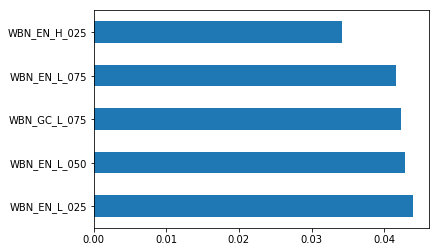

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
%matplotlib inline

# Select best features for the label
model = ExtraTreesClassifier()
model.fit(x_train, y_train)

feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [8]:
# Create dataframe with olny the best features
x_train = x_train[['WBN_EN_L_050', 'MW', 'WBN_GC_L_100', 'WBN_EN_L_075', 'WBN_EN_L_025']]

x_test = x_test[['WBN_EN_L_050', 'MW', 'WBN_GC_L_100', 'WBN_EN_L_075', 'WBN_EN_L_025']]

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras import layers


model = Sequential()
model.add(Dense(64, input_dim=5, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

opt = optimizers.nadam(lr=.01)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_rx_580.0"


In [10]:
model.fit(x_train, y_train,
          epochs=5,
          batch_size=128)

Epoch 1/5
47826/47826 [==============================] - 3s 63us/step - loss: 0.0294 - acc: 0.9978
Epoch 2/5
47826/47826 [==============================] - 2s 43us/step - loss: 0.0182 - acc: 0.9989
Epoch 3/5
47826/47826 [==============================] - 2s 41us/step - loss: 0.0182 - acc: 0.9989
Epoch 4/5
47826/47826 [==============================] - 2s 44us/step - loss: 0.0182 - acc: 0.9989
Epoch 5/5
47826/47826 [==============================] - 2s 42us/step - loss: 0.0182 - acc: 0.9989


In [11]:
score = model.evaluate(x_test, y_test, batch_size=128)
print('Score', score)

11956/11956 [==============================] - 1s 43us/step
Score [0.017525653130809324, 0.9989126798260288]
